In [ ]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download and explore the dataset !!

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [ ]:
print(image_count)

3670


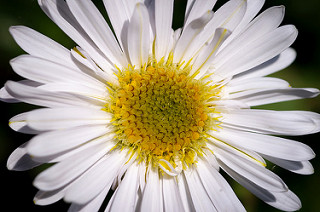

In [ ]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[3]))

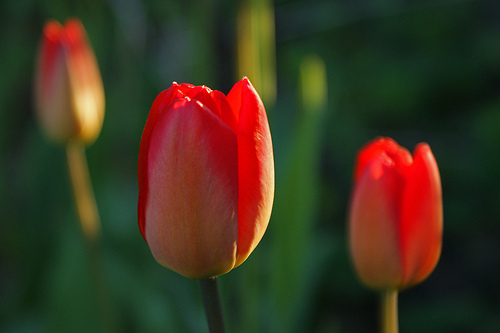

In [ ]:
tulip = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulip[2]))

**Create a dataset**

In [ ]:
#Define some parameter for the loader

batch_size = 32
image_height = 180
image_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size = (image_height, image_width),
    batch_size = (batch_size)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=(image_height, image_width),
    batch_size=(batch_size)
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Visualize thee data

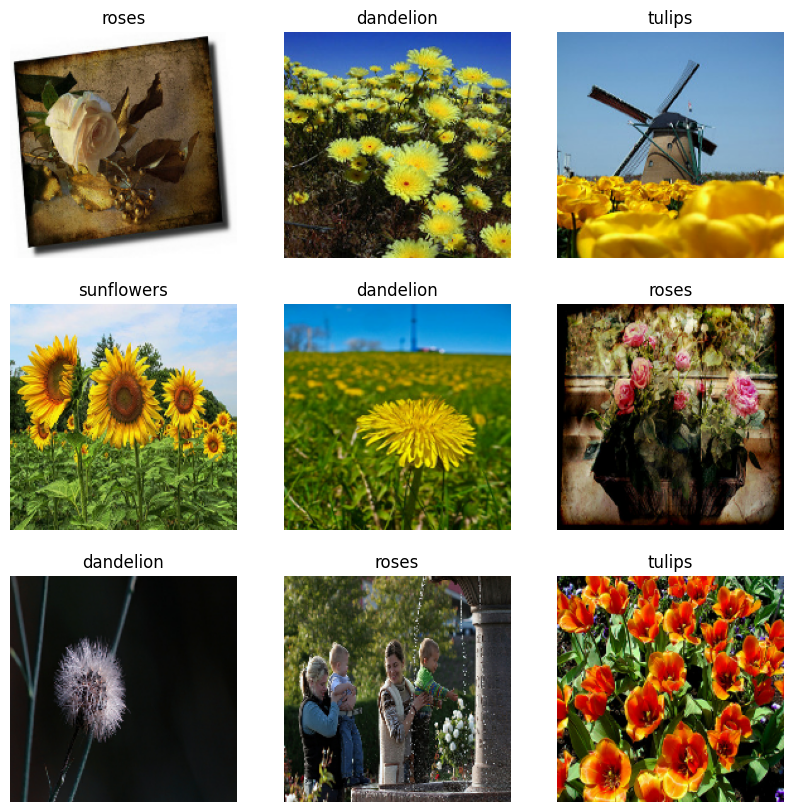

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batches, labels_batches in train_ds:
  print(image_batches.shape)
  print(labels_batches.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 16s 38ms/step - loss: 1.4481 - accuracy: 0.3893 - val_loss: 1.2748 - val_accuracy: 0.4632
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.0680 - accuracy: 0.5654 - val_loss: 1.0851 - val_accuracy: 0.5286
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9173 - accuracy: 0.6495 - val_loss: 0.9957 - val_accuracy: 0.6063
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7242 - accuracy: 0.7343 - val_loss: 0.9267 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.5237 - accuracy: 0.8048 - val_loss: 1.0386 - val_accuracy: 0.6063
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3277 - accuracy: 0.8862 - val_loss: 1.2195 - val_accuracy: 0.6226
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2082 - accuracy: 0.9326 - val_loss: 1.3129 - val_accuracy: 0.6199
Epoch 8/10
9

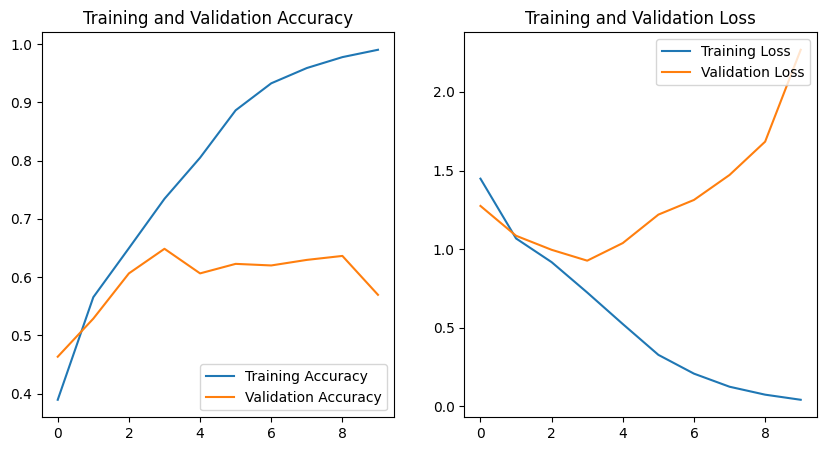

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Overfitting**

**Data augmentation**

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(image_height, image_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

To show augmented images

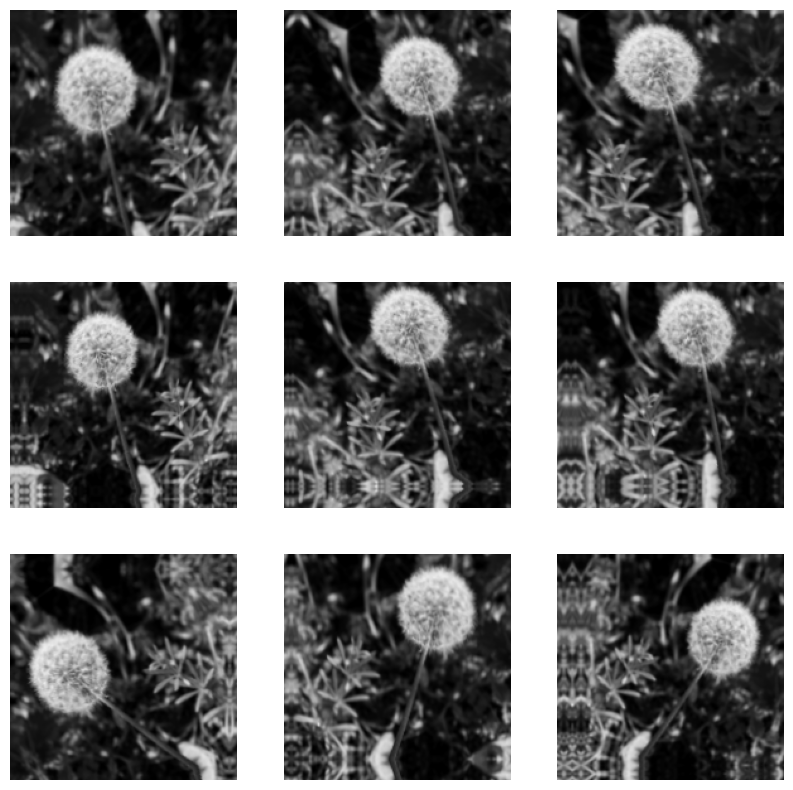

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 5s 32ms/step - loss: 1.4759 - accuracy: 0.3713 - val_loss: 1.2096 - val_accuracy: 0.4741
Epoch 2/20
92/92 [==============================] - 3s 30ms/step - loss: 1.1545 - accuracy: 0.5245 - val_loss: 1.1139 - val_accuracy: 0.5708
Epoch 3/20
92/92 [==============================] - 3s 33ms/step - loss: 1.0625 - accuracy: 0.5702 - val_loss: 1.1628 - val_accuracy: 0.5817
Epoch 4/20
92/92 [==============================] - 3s 30ms/step - loss: 0.9704 - accuracy: 0.6250 - val_loss: 1.0258 - val_accuracy: 0.6035
Epoch 5/20
92/92 [==============================] - 3s 31ms/step - loss: 0.9093 - accuracy: 0.6478 - val_loss: 0.9344 - val_accuracy: 0.6499
Epoch 6/20
92/92 [==============================] - 3s 31ms/step - loss: 0.8651 - accuracy: 0.6686 - val_loss: 1.0358 - val_accuracy: 0.6049
Epoch 7/20
92/92 [==============================] - 3s 31ms/step - loss: 0.8159 - accuracy: 0.6880 - val_loss: 0.8388 - val_accuracy: 0.6717
Epoch 8/20
92

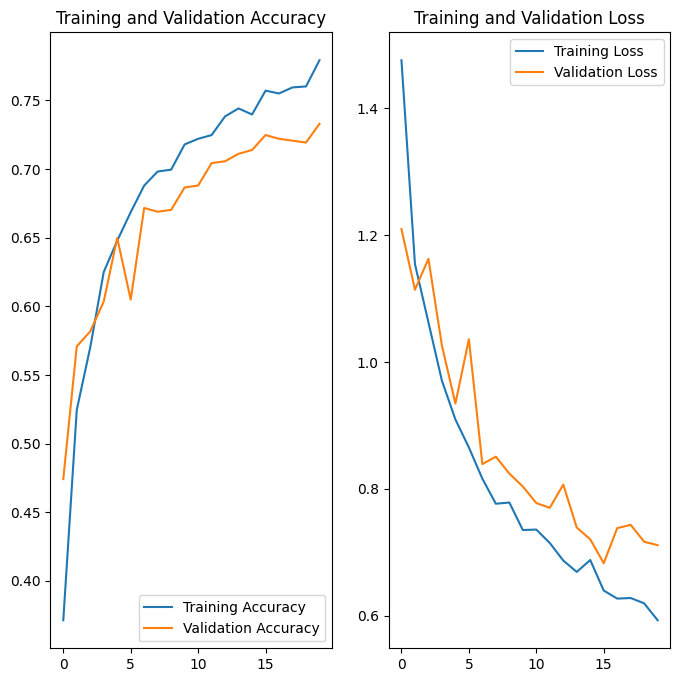

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

In [ ]:
# tulip_url = input('Enter image')
img_path = input('enter image')
#tf.keras.utils.get_file('tulips', origin=tulip_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

enter image/content/download.jpeg
1/1 [==============================] - 0s 214ms/step
This image most likely belongs to sunflowers with a 95.92 percent confidence.


Save the model

---



In [ ]:
# Assuming 'model' is your trained model
# Save the model architecture and weights
model.save('/content/drive/My Drive/mmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Load Model

In [ ]:
from tensorflow.keras.models import load_model

# Assuming the model is located at 'My Drive/Path/to/your/model.h5'
model_path = '/content/drive/MyDrive/mmodel.h5'
loaded_model = load_model(model_path)

In [ ]:
img_path = input('enter image')

img = tf.keras.utils.load_img(
    img_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

enter image/content/d2.jpg
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to dandelion with a 87.69 percent confidence.
